In [61]:
"""
A benchmarking framework for Autocorrelation Function (ACF) estimation methods (Direct, FFT-based, AR(p) and EWMA).
"""
# Imports
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
# others...

""" Global parameters """
N_LIST = [256, 512, 1024, 2048, 4096]  # Sample sizes
# others...

""" Method-specific parameters """
AR_ORDER = 5  # Order for AR(p) method
FORGETTING_FACTOR = 0.9  # Forgetting factor for EWMA method
# others...


In [62]:
""" TESTING SIGNAL GENERATION """
# Benchmark process: x[n] = A*cos(omega0*n + phi) + AWGN, with phi ~ U[-pi, pi).

from collections.abc import Sequence

from common.awgn import awgn

DEFAULT_NUM_REALIZATIONS = 256
DEFAULT_SIGNAL_AMPLITUDE = 1.0
DEFAULT_OMEGA0_RAD_PER_SAMPLE = 0.2 * np.pi
DEFAULT_SNR_DB = 12.0
DEFAULT_RANDOM_PHASE = True
DEFAULT_PHASE_LOW_RAD = -np.pi
DEFAULT_PHASE_HIGH_RAD = np.pi
DEFAULT_SEED = 7
DEFAULT_SIGNAL_BANK_SAMPLE_SIZES: tuple[int, ...] = (256, 512, 1024, 2048, 4096)


def _validate_positive_integer(
    value: int | np.integer,           # Candidate positive integer parameter
    parameter_name: str,               # Human-readable name used in error messages
) -> int:                              # Validated integer value
    """Validates that a parameter is a strictly positive integer."""
    if not isinstance(value, (int, np.integer)) or int(value) <= 0:
        raise ValueError(f"{parameter_name} must be a positive integer.")
    return int(value)


def _validate_real_scalar(
    value: float,                      # Candidate scalar parameter value
    parameter_name: str,               # Human-readable name used in error messages
) -> float:                            # Validated finite scalar value
    """Validates that a parameter is a finite real scalar."""
    try:
        scalar_value = float(value)
    except (TypeError, ValueError) as exc:
        raise ValueError(f"{parameter_name} must be a real scalar.") from exc

    if not np.isfinite(scalar_value):
        raise ValueError(f"{parameter_name} must be finite.")

    return scalar_value


def _validate_optional_seed(
    seed: int | np.integer | None,     # Optional deterministic seed
) -> int | None:                       # Validated integer seed or None
    """Validates optional integer seed inputs used for reproducible RNG streams."""
    if seed is None:
        return None
    if not isinstance(seed, (int, np.integer)):
        raise TypeError("seed must be an integer when provided.")
    return int(seed)


def _resolve_floating_dtype(
    dtype: np.dtype | type[np.floating],  # Requested dtype for generated samples
) -> np.dtype:                             # Validated floating dtype
    """Validates and returns a floating-point NumPy dtype."""
    resolved_dtype = np.dtype(dtype)
    if not np.issubdtype(resolved_dtype, np.floating):
        raise TypeError("dtype must be a floating-point numpy dtype.")
    return resolved_dtype


def _resolve_rng(
    seed: int | np.integer | None = None,  # Optional integer seed for local RNG creation
    rng: np.random.Generator | None = None,  # Optional externally managed RNG instance
) -> np.random.Generator:                   # Generator used by phase and AWGN sampling
    """
    Resolves a single RNG source while preventing ambiguous RNG configuration.

    Purpose
    -------
    Centralize RNG construction so all generation paths use deterministic,
    explicit random-state rules.

    Parameters
    ----------
    seed : int | np.integer | None
        Optional seed used to construct a local ``np.random.Generator``.
    rng : np.random.Generator | None
        Optional generator provided by the caller.

    Returns
    -------
    np.random.Generator
        RNG used for all random draws in the calling function.

    Side Effects
    ------------
    None.

    Assumptions
    -----------
    ``seed`` and ``rng`` must not be provided simultaneously.
    """
    # Keep RNG ownership explicit to avoid accidental state coupling.
    if seed is not None and rng is not None:
        raise ValueError("Provide either 'seed' or 'rng', but not both.")
    if rng is not None:
        if not isinstance(rng, np.random.Generator):
            raise TypeError("rng must be a numpy.random.Generator when provided.")
        return rng

    validated_seed = _validate_optional_seed(seed)
    return np.random.default_rng(validated_seed)


def _derive_rng_for_sample_size(
    sample_size: int | np.integer,           # Sample size index key [samples]
    base_seed: int | np.integer | None,      # Base seed used for deterministic per-N derivation
) -> np.random.Generator:                   # Dedicated RNG stream for the provided sample size
    """
    Derives a per-sample-size RNG with order- and set-invariant mapping.

    Purpose
    -------
    Guarantee that each ``N`` always maps to the same RNG stream when
    ``base_seed`` is fixed, independently of the presence or ordering of other
    sample sizes in the same bank request.

    Parameters
    ----------
    sample_size : int | np.integer
        Sample size key used to identify one bank entry [samples].
    base_seed : int | np.integer | None
        Base seed used as the deterministic root. If None, OS entropy is used
        and mapping is intentionally non-deterministic across runs.

    Returns
    -------
    np.random.Generator
        RNG stream dedicated to the given ``sample_size``.

    Side Effects
    ------------
    None.

    Assumptions
    -----------
    ``sample_size`` is a positive integer.
    """
    validated_sample_size = _validate_positive_integer(sample_size, "sample_size")
    validated_base_seed = _validate_optional_seed(base_seed)

    # Preserve existing behavior for entropy-based runs while keeping per-N isolation.
    if validated_base_seed is None:
        return np.random.default_rng()

    # Use an explicit entropy tuple so each N has a stable deterministic stream.
    seed_sequence = np.random.SeedSequence([validated_base_seed, validated_sample_size])
    return np.random.default_rng(seed_sequence)


def _format_generation_output(
    clean_signal: np.ndarray,                                  # Deterministic clean component [signal units]
    noisy_signal: np.ndarray,                                  # Final noisy output component [signal units]
    return_components: bool = False,                           # If True, return (clean, noise, noisy)
) -> np.ndarray | tuple[np.ndarray, np.ndarray, np.ndarray]:  # Noisy output or debug tuple
    """
    Returns generation outputs in production or debug format.

    Purpose
    -------
    Centralize optional debug output construction so all generators expose the
    same ``return_components`` behavior.

    Parameters
    ----------
    clean_signal : np.ndarray
        Deterministic clean signal component.
    noisy_signal : np.ndarray
        Final noisy signal returned by the generator.
    return_components : bool
        If True, return ``(clean_signal, noise_component, noisy_signal)`` where
        ``noise_component = noisy_signal - clean_signal``.

    Returns
    -------
    np.ndarray | tuple[np.ndarray, np.ndarray, np.ndarray]
        ``noisy_signal`` when ``return_components`` is False, otherwise a tuple
        ``(clean_signal, noise_component, noisy_signal)``.

    Side Effects
    ------------
    None.

    Assumptions
    -----------
    ``clean_signal`` and ``noisy_signal`` have identical shapes.
    """
    if not isinstance(return_components, bool):
        raise TypeError("return_components must be a bool.")

    if return_components:
        # Keep the effective perturbation aligned with the returned noisy output.
        noise_component = (noisy_signal - clean_signal).astype(noisy_signal.dtype, copy=False)
        return clean_signal, noise_component, noisy_signal

    return noisy_signal


def _inject_awgn_ensemble(
    clean_signal_matrix: np.ndarray,       # Deterministic clean matrix, shape (R, N)
    snr_db: float,                         # Target SNR [dB]
    rng: np.random.Generator,              # RNG consumed by AWGN draws
    batch_awgn: bool = True,               # If True, allow one matrix-level AWGN call
    enforce_per_realization_snr: bool = False,  # If True, always enforce row-wise AWGN/SNR
) -> np.ndarray:                           # AWGN-perturbed matrix, shape (R, N)
    """
    Injects AWGN into an ensemble with explicit SNR-scope control.

    Purpose
    -------
    Make matrix-level (global) versus row-level (per realization) SNR semantics
    explicit and reproducible while reusing the canonical ``awgn`` API.

    Parameters
    ----------
    clean_signal_matrix : np.ndarray
        Deterministic clean matrix with shape ``(num_realizations, num_samples)``.
    snr_db : float
        Target SNR in decibels [dB].
    rng : np.random.Generator
        RNG used by ``awgn``.
    batch_awgn : bool
        If True and ``enforce_per_realization_snr`` is False, call ``awgn`` once
        on the full matrix, which enforces a global matrix-level SNR.
    enforce_per_realization_snr : bool
        If True, apply ``awgn`` independently on each row to enforce per-row SNR
        regardless of ``batch_awgn``.

    Returns
    -------
    np.ndarray
        Noisy matrix with the same shape and dtype as ``clean_signal_matrix``.

    Side Effects
    ------------
    Consumes random numbers from ``rng``.

    Assumptions
    -----------
    ``clean_signal_matrix`` is 2D.
    """
    if not isinstance(batch_awgn, bool):
        raise TypeError("batch_awgn must be a bool.")
    if not isinstance(enforce_per_realization_snr, bool):
        raise TypeError("enforce_per_realization_snr must be a bool.")

    # Matrix-level AWGN preserves existing behavior: SNR is global over all rows.
    if batch_awgn and not enforce_per_realization_snr:
        return awgn(
            clean_signal_matrix,
            snr_db=snr_db,
            rng=rng,
            preserve_dtype=True,
        )

    # Row-wise AWGN enforces per-realization SNR independently.
    num_realizations = clean_signal_matrix.shape[0]
    noisy_signal_matrix = np.empty_like(clean_signal_matrix)
    for realization_index in range(num_realizations):
        noisy_signal_matrix[realization_index, :] = awgn(
            clean_signal_matrix[realization_index, :],
            snr_db=snr_db,
            rng=rng,
            preserve_dtype=True,
        )

    return noisy_signal_matrix


def _draw_phase_vector_rad(
    num_realizations: int,             # Number of realizations (rows)
    random_phase: bool,                # If True, draw one random phase per realization
    phase_rad: float,                  # Shared phase when random_phase is False [rad]
    rng: np.random.Generator,          # RNG used for uniform phase sampling
) -> np.ndarray:                       # Phase vector with shape (num_realizations, 1)
    """
    Generates per-realization phases using the unified convention U[-pi, pi).

    Purpose
    -------
    Provide a single phase policy used consistently by all benchmark generators.

    Parameters
    ----------
    num_realizations : int
        Number of realizations (rows).
    random_phase : bool
        If True, draw ``phi_i ~ Uniform(-pi, pi)`` independently for each row.
        If False, use the shared deterministic phase ``phase_rad``.
    phase_rad : float
        Shared phase used when ``random_phase`` is False [rad].
    rng : np.random.Generator
        RNG used for phase draws.

    Returns
    -------
    np.ndarray
        Phase column vector with shape ``(num_realizations, 1)`` [rad].

    Side Effects
    ------------
    Consumes random numbers from ``rng`` when ``random_phase`` is True.

    Assumptions
    -----------
    ``num_realizations`` has already been validated as positive.
    """
    # Keep the phase convention fixed and explicit across code and docstrings.
    if not isinstance(random_phase, bool):
        raise TypeError("random_phase must be a bool.")

    if random_phase:
        return rng.uniform(
            low=DEFAULT_PHASE_LOW_RAD,
            high=DEFAULT_PHASE_HIGH_RAD,
            size=(num_realizations, 1),
        )

    validated_phase_rad = _validate_real_scalar(phase_rad, "phase_rad")
    return np.full((num_realizations, 1), validated_phase_rad, dtype=np.float64)


def generate_clean_cosine(
    num_samples: int,                                        # Number of samples in the realization [samples]
    amplitude: float = DEFAULT_SIGNAL_AMPLITUDE,             # Cosine amplitude [signal units]
    omega0_rad_per_sample: float = DEFAULT_OMEGA0_RAD_PER_SAMPLE,  # Angular frequency [rad/sample]
    phase_rad: float = 0.0,                                  # Initial phase [rad]
    normalize_omega0: bool = False,                          # If True, wrap omega0 to [0, 2*pi) [rad/sample]
    dtype: np.dtype | type[np.floating] = np.float64,        # Floating dtype for generated samples
) -> np.ndarray:                                             # Clean sinusoidal realization
    """
    Generates a clean sinusoidal benchmark realization.

    Purpose
    -------
    Build the deterministic component ``s[n] = A*cos(omega0*n + phi)`` used
    before AWGN injection in ACF benchmarking experiments.

    Parameters
    ----------
    num_samples : int
        Number of discrete-time samples to generate [samples].
    amplitude : float
        Sinusoid amplitude in signal units.
    omega0_rad_per_sample : float
        Angular frequency of the sinusoid [rad/sample].
    phase_rad : float
        Initial phase offset [rad].
    normalize_omega0 : bool
        If True, normalize ``omega0_rad_per_sample`` to ``[0, 2*pi)`` before
        synthesis so equivalent discrete-time frequencies share one canonical
        representation.
    dtype : np.dtype | type[np.floating]
        Floating dtype used for the output array.

    Returns
    -------
    np.ndarray
        Clean sinusoidal sequence with shape ``(num_samples,)``.

    Side Effects
    ------------
    None.

    Assumptions
    -----------
    ``num_samples > 0`` and all scalar parameters are finite real values.
    """
    # Validate scalar parameters before building the sample grid.
    validated_num_samples = _validate_positive_integer(num_samples, "num_samples")
    amplitude_value = _validate_real_scalar(amplitude, "amplitude")
    omega0_value = _validate_real_scalar(omega0_rad_per_sample, "omega0_rad_per_sample")
    phase_value = _validate_real_scalar(phase_rad, "phase_rad")
    if not isinstance(normalize_omega0, bool):
        raise TypeError("normalize_omega0 must be a bool.")
    if normalize_omega0:
        omega0_value = float(np.mod(omega0_value, 2.0 * np.pi))
    resolved_dtype = _resolve_floating_dtype(dtype)

    # Use float64 internally for stable phase accumulation, then cast at the end.
    sample_index = np.arange(validated_num_samples, dtype=np.float64)
    clean_signal = amplitude_value * np.cos(omega0_value * sample_index + phase_value)
    return clean_signal.astype(resolved_dtype, copy=False)


def generate_noisy_benchmark_signal(
    num_samples: int,                                        # Number of samples in the realization [samples]
    amplitude: float = DEFAULT_SIGNAL_AMPLITUDE,             # Cosine amplitude [signal units]
    omega0_rad_per_sample: float = DEFAULT_OMEGA0_RAD_PER_SAMPLE,  # Angular frequency [rad/sample]
    phase_rad: float = 0.0,                                  # Initial phase [rad]
    normalize_omega0: bool = False,                          # If True, wrap omega0 to [0, 2*pi) [rad/sample]
    snr_db: float = DEFAULT_SNR_DB,                          # Target SNR for AWGN injection [dB]
    rng: np.random.Generator | None = None,                  # Optional RNG consumed by AWGN generation
    demean: bool = False,                                    # If True, demean after AWGN (changes effective output SNR)
    return_components: bool = False,                         # If True, return (clean, noise, noisy)
    dtype: np.dtype | type[np.floating] = np.float64,        # Floating dtype for generated samples
) -> np.ndarray | tuple[np.ndarray, np.ndarray, np.ndarray]:  # Noisy output or debug tuple
    """
    Generates one noisy benchmark realization using the shared AWGN API.

    Purpose
    -------
    Create ``x[n] = A*cos(omega0*n + phi) + w[n]`` where ``w[n]`` is generated
    strictly through ``common.awgn.awgn`` with SNR in decibels.

    Parameters
    ----------
    num_samples : int
        Number of samples in the realization [samples].
    amplitude : float
        Deterministic sinusoid amplitude in signal units.
    omega0_rad_per_sample : float
        Sinusoid angular frequency [rad/sample].
    phase_rad : float
        Initial sinusoid phase [rad].
    normalize_omega0 : bool
        If True, normalize ``omega0_rad_per_sample`` to ``[0, 2*pi)`` before
        generating the clean sinusoid.
    snr_db : float
        Target signal-to-noise ratio used by ``awgn`` [dB].
    rng : np.random.Generator | None
        Optional RNG consumed by ``awgn`` for reproducible noise.
    demean : bool
        If True, subtract the realization mean after AWGN injection. This
        modifies final signal/noise powers, so output SNR is no longer exactly
        equal to ``snr_db``.
    return_components : bool
        If True, return ``(clean_signal, noise_component, noisy_signal)`` where
        ``noise_component`` matches the final returned output semantics.
    dtype : np.dtype | type[np.floating]
        Floating dtype of the clean signal and output sequence.

    Returns
    -------
    np.ndarray | tuple[np.ndarray, np.ndarray, np.ndarray]
        ``noisy_signal`` with shape ``(num_samples,)`` when
        ``return_components`` is False, otherwise ``(clean, noise, noisy)``.

    Side Effects
    ------------
    Consumes random numbers from ``rng`` when finite ``snr_db`` is used.

    Assumptions
    -----------
    ``common.awgn.awgn`` remains the canonical noise-generation implementation.
    ``snr_db`` is enforced at AWGN injection time, before optional demeaning.
    """
    # Validate local options and generate the deterministic sinusoid.
    if not isinstance(demean, bool):
        raise TypeError("demean must be a bool.")
    resolved_dtype = _resolve_floating_dtype(dtype)
    clean_signal = generate_clean_cosine(
        num_samples=num_samples,
        amplitude=amplitude,
        omega0_rad_per_sample=omega0_rad_per_sample,
        phase_rad=phase_rad,
        normalize_omega0=normalize_omega0,
        dtype=resolved_dtype,
    )

    # Inject AWGN via SNR using the shared API (no manual noise synthesis here).
    noisy_signal = awgn(clean_signal, snr_db=snr_db, rng=rng, preserve_dtype=True)

    # Optional demeaning supports autocovariance-oriented ACF estimators.
    # Note: this changes output SNR because the operation happens after AWGN.
    if demean:
        noisy_signal = (noisy_signal - np.mean(noisy_signal, dtype=np.float64)).astype(
            resolved_dtype,
            copy=False,
        )

    return _format_generation_output(
        clean_signal=clean_signal,
        noisy_signal=noisy_signal,
        return_components=return_components,
    )


def generate_benchmark_ensemble(
    num_realizations: int = DEFAULT_NUM_REALIZATIONS,        # Number of independent realizations (rows)
    num_samples: int = 1024,                                 # Number of samples per realization [samples]
    amplitude: float = DEFAULT_SIGNAL_AMPLITUDE,             # Cosine amplitude [signal units]
    omega0_rad_per_sample: float = DEFAULT_OMEGA0_RAD_PER_SAMPLE,  # Angular frequency [rad/sample]
    normalize_omega0: bool = False,                          # If True, wrap omega0 to [0, 2*pi) [rad/sample]
    snr_db: float = DEFAULT_SNR_DB,                          # Target SNR for AWGN injection [dB]
    random_phase: bool = DEFAULT_RANDOM_PHASE,               # If True, draw independent phase per realization
    phase_rad: float = 0.0,                                  # Shared phase when random_phase is False [rad]
    seed: int | np.integer | None = DEFAULT_SEED,            # Optional seed for reproducible local RNG
    rng: np.random.Generator | None = None,                  # Optional externally managed RNG
    demean_per_realization: bool = False,                    # If True, subtract row-wise means after AWGN
    batch_awgn: bool = True,                                 # If True, permit one matrix-level AWGN call
    enforce_per_realization_snr: bool = False,               # If True, enforce per-row SNR even when batch_awgn=True
    return_components: bool = False,                         # If True, return (clean, noise, noisy)
    dtype: np.dtype | type[np.floating] = np.float64,        # Floating dtype for generated matrix
) -> np.ndarray | tuple[np.ndarray, np.ndarray, np.ndarray]:  # Matrix output or debug tuple
    """
    Generates an ensemble of noisy benchmark signals for Monte Carlo ACF studies.

    Purpose
    -------
    Build a reproducible realization matrix while keeping a single, explicit
    phase convention ``phi_i ~ Uniform(-pi, pi)`` and SNR-based AWGN injection.

    Parameters
    ----------
    num_realizations : int
        Number of independent realizations (rows).
    num_samples : int
        Number of samples per realization [samples].
    amplitude : float
        Deterministic sinusoid amplitude in signal units.
    omega0_rad_per_sample : float
        Sinusoid angular frequency [rad/sample].
    normalize_omega0 : bool
        If True, normalize ``omega0_rad_per_sample`` to ``[0, 2*pi)`` before
        sinusoid synthesis.
    snr_db : float
        Target signal-to-noise ratio [dB], validated by ``awgn``.
    random_phase : bool
        If True, each realization uses ``phi_i ~ Uniform(-pi, pi)``.
        If False, all realizations use ``phase_rad``.
    phase_rad : float
        Shared phase used when ``random_phase`` is False [rad].
    seed : int | np.integer | None
        Optional seed for creating a local RNG. Mutually exclusive with ``rng``.
    rng : np.random.Generator | None
        Optional externally managed RNG for reproducible pipelines.
    demean_per_realization : bool
        If True, subtract each row mean after noise injection. This changes
        final row powers, so output SNR differs from the requested ``snr_db``.
    batch_awgn : bool
        If True, allow one matrix-level AWGN call. In that mode and when
        ``enforce_per_realization_snr`` is False, SNR is global over the full
        matrix, not per realization.
    enforce_per_realization_snr : bool
        If True, apply ``awgn`` independently per row so each realization
        receives its own SNR target regardless of ``batch_awgn``.
    return_components : bool
        If True, return ``(clean_signal_matrix, noise_matrix, noisy_matrix)``.
    dtype : np.dtype | type[np.floating]
        Floating dtype used by the returned matrix.

    Returns
    -------
    np.ndarray | tuple[np.ndarray, np.ndarray, np.ndarray]
        ``noisy_signal_matrix`` with shape ``(num_realizations, num_samples)``
        when ``return_components`` is False, otherwise ``(clean, noise, noisy)``.

    Side Effects
    ------------
    Consumes random numbers from the active RNG for phase and noise draws.

    Assumptions
    -----------
    Realizations are independent conditioned on the active RNG stream.
    """
    # Validate dimensions and scalar configuration before allocating memory.
    validated_num_realizations = _validate_positive_integer(num_realizations, "num_realizations")
    validated_num_samples = _validate_positive_integer(num_samples, "num_samples")
    amplitude_value = _validate_real_scalar(amplitude, "amplitude")
    omega0_value = _validate_real_scalar(omega0_rad_per_sample, "omega0_rad_per_sample")
    if not isinstance(normalize_omega0, bool):
        raise TypeError("normalize_omega0 must be a bool.")
    if normalize_omega0:
        omega0_value = float(np.mod(omega0_value, 2.0 * np.pi))
    if not isinstance(demean_per_realization, bool):
        raise TypeError("demean_per_realization must be a bool.")
    resolved_dtype = _resolve_floating_dtype(dtype)

    # Resolve one RNG so phase and AWGN streams stay deterministic together.
    rng_obj = _resolve_rng(seed=seed, rng=rng)

    # Vectorize deterministic cosine generation using phase and sample broadcasting.
    phase_vector_rad = _draw_phase_vector_rad(
        num_realizations=validated_num_realizations,
        random_phase=random_phase,
        phase_rad=phase_rad,
        rng=rng_obj,
    )
    sample_index = np.arange(validated_num_samples, dtype=np.float64)[None, :]
    clean_signal_matrix = amplitude_value * np.cos(omega0_value * sample_index + phase_vector_rad)
    clean_signal_matrix = clean_signal_matrix.astype(resolved_dtype, copy=False)

    # Inject AWGN with explicit global-vs-per-row SNR semantics.
    noisy_signal_matrix = _inject_awgn_ensemble(
        clean_signal_matrix=clean_signal_matrix,
        snr_db=snr_db,
        rng=rng_obj,
        batch_awgn=batch_awgn,
        enforce_per_realization_snr=enforce_per_realization_snr,
    )

    # Optional row-wise demeaning supports autocovariance estimators.
    # Note: this post-AWGN operation slightly changes effective output SNR.
    if demean_per_realization:
        row_means = np.mean(noisy_signal_matrix, axis=1, keepdims=True, dtype=np.float64)
        noisy_signal_matrix = (noisy_signal_matrix - row_means).astype(resolved_dtype, copy=False)

    return _format_generation_output(
        clean_signal=clean_signal_matrix,
        noisy_signal=noisy_signal_matrix,
        return_components=return_components,
    )


def generate_signal_bank(
    sample_sizes: Sequence[int | np.integer] | None = None,  # Distinct sample sizes used as bank keys [samples]
    num_realizations: int = DEFAULT_NUM_REALIZATIONS,        # Number of realizations per sample size
    amplitude: float = DEFAULT_SIGNAL_AMPLITUDE,             # Cosine amplitude [signal units]
    omega0_rad_per_sample: float = DEFAULT_OMEGA0_RAD_PER_SAMPLE,  # Angular frequency [rad/sample]
    normalize_omega0: bool = False,                          # If True, wrap omega0 to [0, 2*pi) [rad/sample]
    snr_db: float = DEFAULT_SNR_DB,                          # Target SNR for AWGN injection [dB]
    random_phase: bool = DEFAULT_RANDOM_PHASE,               # If True, draw independent phase per realization
    phase_rad: float = 0.0,                                  # Shared phase when random_phase is False [rad]
    base_seed: int | np.integer | None = DEFAULT_SEED,       # Global seed used to derive per-N RNG streams
    demean_per_realization: bool = False,                    # If True, subtract row-wise means after AWGN
    batch_awgn: bool = True,                                 # If True, permit one matrix-level AWGN call per N
    enforce_per_realization_snr: bool = False,               # If True, enforce per-row SNR for each N
    return_components: bool = False,                         # If True, return (clean, noise, noisy) per N
    dtype: np.dtype | type[np.floating] = np.float64,        # Floating dtype for generated matrices
) -> dict[int, np.ndarray | tuple[np.ndarray, np.ndarray, np.ndarray]]:  # Mapping N -> output matrix or debug tuple
    """
    Generates a benchmark bank indexed by sample size with order- and set-invariant RNG mapping.

    Purpose
    -------
    Build one realization matrix per sample size while guaranteeing that
    adding, removing, or reordering ``sample_sizes`` does not alter the random
    stream assigned to any existing ``N``.

    Parameters
    ----------
    sample_sizes : Sequence[int | np.integer] | None
        Distinct sample sizes for each bank entry [samples]. When None, use the
        notebook-local fallback ``DEFAULT_SIGNAL_BANK_SAMPLE_SIZES``.
    num_realizations : int
        Number of realizations generated per sample size.
    amplitude : float
        Deterministic sinusoid amplitude in signal units.
    omega0_rad_per_sample : float
        Sinusoid angular frequency [rad/sample].
    normalize_omega0 : bool
        If True, normalize ``omega0_rad_per_sample`` to ``[0, 2*pi)`` before
        generating each bank entry.
    snr_db : float
        Target signal-to-noise ratio [dB], validated by ``awgn``.
    random_phase : bool
        If True, each realization uses ``phi_i ~ Uniform(-pi, pi)``.
    phase_rad : float
        Shared phase used when ``random_phase`` is False [rad].
    base_seed : int | np.integer | None
        Base seed used for deterministic per-``N`` RNG derivation. None uses
        OS entropy and therefore produces non-deterministic streams per run.
    demean_per_realization : bool
        If True, subtract each row mean after noise injection (which changes
        effective output SNR relative to ``snr_db``).
    batch_awgn : bool
        If True, allow one matrix-level AWGN call per ``N``.
    enforce_per_realization_snr : bool
        If True, enforce per-row SNR for each realization per ``N``.
    return_components : bool
        If True, each dictionary value is ``(clean, noise, noisy)``.
    dtype : np.dtype | type[np.floating]
        Floating dtype used for all bank matrices.

    Returns
    -------
    dict[int, np.ndarray | tuple[np.ndarray, np.ndarray, np.ndarray]]
        Dictionary mapping sample size ``N`` to a matrix output, or to
        ``(clean, noise, noisy)`` when ``return_components`` is True.

    Side Effects
    ------------
    Consumes random numbers from per-size RNG streams derived as
    ``SeedSequence([base_seed, N])`` when ``base_seed`` is provided.

    Assumptions
    -----------
    ``sample_sizes`` contains unique positive integers.
    """
    # Resolve sample-size keys before validation to avoid hidden global coupling.
    if sample_sizes is None:
        sample_sizes = DEFAULT_SIGNAL_BANK_SAMPLE_SIZES

    # Validate bank keys and enforce uniqueness for deterministic mapping.
    validated_sample_sizes = tuple(
        _validate_positive_integer(sample_size, "sample_sizes entries")
        for sample_size in sample_sizes
    )
    if len(validated_sample_sizes) == 0:
        raise ValueError("sample_sizes must contain at least one sample size.")
    if len(set(validated_sample_sizes)) != len(validated_sample_sizes):
        raise ValueError("sample_sizes must contain unique values.")

    resolved_dtype = _resolve_floating_dtype(dtype)
    validated_base_seed = _validate_optional_seed(base_seed)

    # Derive one independent RNG per N from (base_seed, N) for set invariance.
    rng_per_size = {
        sample_size: _derive_rng_for_sample_size(
            sample_size=sample_size,
            base_seed=validated_base_seed,
        )
        for sample_size in validated_sample_sizes
    }

    # Generate each bank entry with its dedicated RNG stream.
    signal_bank: dict[int, np.ndarray | tuple[np.ndarray, np.ndarray, np.ndarray]] = {}
    for sample_size in validated_sample_sizes:
        signal_bank[sample_size] = generate_benchmark_ensemble(
            num_realizations=num_realizations,
            num_samples=sample_size,
            amplitude=amplitude,
            omega0_rad_per_sample=omega0_rad_per_sample,
            normalize_omega0=normalize_omega0,
            snr_db=snr_db,
            random_phase=random_phase,
            phase_rad=phase_rad,
            seed=None,
            rng=rng_per_size[sample_size],
            demean_per_realization=demean_per_realization,
            batch_awgn=batch_awgn,
            enforce_per_realization_snr=enforce_per_realization_snr,
            return_components=return_components,
            dtype=resolved_dtype,
        )

    return signal_bank


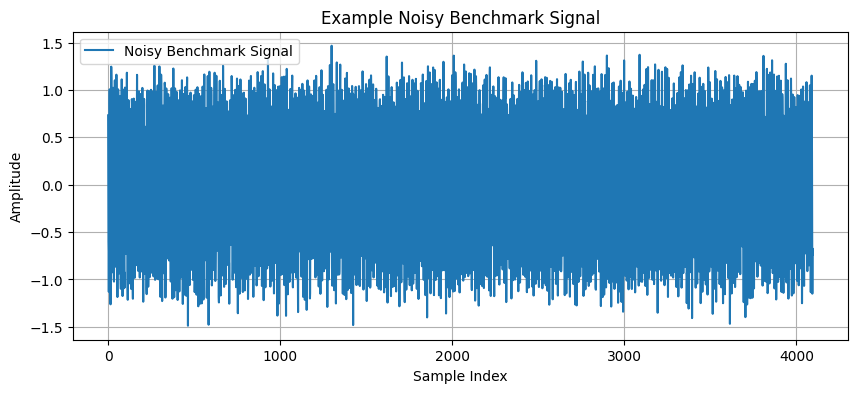

In [63]:
# Example signal
plt.figure(figsize=(10, 4))
plt.plot(benchmark_signals[0, :], label="Noisy Benchmark Signal")
plt.title("Example Noisy Benchmark Signal")
plt.xlabel("Sample Index")
plt.ylabel("Amplitude")
plt.legend()
plt.grid()
plt.show()

In [64]:
""" GROUND TRUTH ACF CALCULATION """
# Standard reference on this scenario: R_x[k] = (A^2 / 2) * cos(omega0 * k) + sigma_w^2 * delta[k]

' GROUND TRUTH ACF CALCULATION '

In [65]:
""" ACF Estimation Methods """
# 1. Direct Method (biased and unbiased)
# 2. FFT-based Method (ACF aperiodic with zero-padding)
# 3. AR(p) Method (Yule-Walker equations)
# 4. EWMA Method (recursive estimation)

' ACF Estimation Methods '

In [66]:
""" BENCHMARKING MODULE """

' BENCHMARKING MODULE '

In [67]:
""" PLOTTING AND ANALYSIS """

' PLOTTING AND ANALYSIS '